In [ ]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


brain_tumor_df = pd.read_csv('Brain Tumor.csv')
bt_dataset_t3_df = pd.read_csv('bt_dataset_t3.csv')

data_df = pd.concat([brain_tumor_df, bt_dataset_t3_df], ignore_index=True)


image_dir = 'images/'
data_df['image_path'] = image_dir + data_df['Image'] + '.jpg'


data_df['Class'] = data_df['Class'].astype(str)
data_df = data_df[data_df['Class'].isin(['0.0', '1.0'])]


train_df, val_df = train_test_split(data_df, test_size=0.2, stratify=data_df['Class'], random_state=42)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='Class',
                                                    target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='Class',
                                                target_size=(150, 150), batch_size=32, class_mode='binary')
print("Classes found by the ImageDataGenerator:")
print(train_generator.class_indices)

Found 3009 validated image filenames belonging to 2 classes.
Found 753 validated image filenames belonging to 2 classes.
Classes found by the ImageDataGenerator:
{'0.0': 0, '1.0': 1}


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

In [92]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)

val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy:.2f}')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step
Epoch 1/10


C:\Users\achraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.6954 - loss: 0.5778 - val_accuracy: 0.8234 - val_loss: 0.3928
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.7919 - loss: 0.4528 - val_accuracy: 0.8420 - val_loss: 0.3575
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.8327 - loss: 0.4036 - val_accuracy: 0.8592 - val_loss: 0.3380
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.8195 - loss: 0.4013 - val_accuracy: 0.8592 - val_loss: 0.3343
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.8306 - loss: 0.3807 - val_accuracy: 0.8645 - val_loss: 0.3152
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.8306 - loss: 0.3906 - val_accuracy: 0.8632 - val_loss: 0.3134
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.8548 - loss: 0.3687 - val_accuracy: 0.8645 - val_loss: 0.3178
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.8470 - loss: 0.3679 - val_accuracy: 0.8685 - val_loss: 0.

In [93]:
import numpy as np
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Prediction: Tumor, Confidence: 99.76%


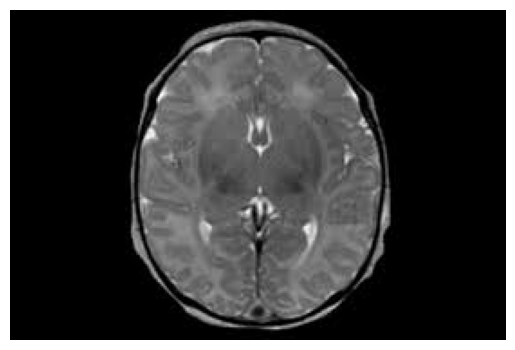

In [113]:
# Le test du model par une image

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    confidence = prediction[0][0] * 100
    diagnosis = 'Tumor' if confidence > 50 else 'No Tumor'
    print(f'Prediction: {diagnosis}, Confidence: {confidence:.2f}%')
    return diagnosis, confidence

img_path = 'images_test/12 no.jpg'
predict_image(model, img_path)

img = image.load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
model.save('brain_tumor_model.h5')